**Named Entity Recognition**

This model was further improved using BiLSTM and CRFs. In the process of
building these models, covered the use of the TensorFlow DataSet API.  also
built advanced models for CRF mode by building a custom Keras layer, a custom
model, custom loss function, and a custom training loop and Vietrbi decoding.

# Installing LIBs

In [96]:
!pip install tensorflow_addons==0.11.2

# Import Libs

In [74]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import csv
import collections
import matplotlib.pyplot as plt
import glob
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM,TimeDistributed, Dense,Layer
from tensorflow.keras import backend as K
from tensorflow.keras import Model, Input, Sequential
from sklearn.model_selection import train_test_split
import tensorflow_addons as tfa


In [2]:
tf.keras.backend.clear_session() #- for easy reset of notebook state


# Loading The  Data

In [ ]:
!wget https://gmb.let.rug.nl/releases/gmb-2.2.0.zip
!unzip gmb-2.2.0.zip

# Preparing The Data

In [3]:
fnames = []
data_root = './gmb-2.2.0/data/'
for root,dirs,files in os.walk(data_root):
  for file_name in files:
    if file_name.endswith('.tags'):
      fnames.append(os.path.join(root,file_name))


In [4]:
fnames[:2]

['./gmb-2.2.0/data/p21/d0192/en.tags', './gmb-2.2.0/data/p21/d0439/en.tags']

## Preprocess Data

In [5]:
!pwd

/content


In [6]:
!mkdir ner

mkdir: cannot create directory ‘ner’: File exists


In [7]:
ner_tags = collections.Counter()
iob_tags = collections.Counter()
def strip_ner_subcat(tag):
  # NER tags are of form {cat}-{subcat}
  # eg tim-dow. We only want first part
  return tag.split("-")[0]

In [8]:
def iob_format(ners):
    # converts IO tags into BIO format
    # input is a sequence of IO NER tokens
    # convert this: O, PERSON, PERSON, O, O, LOCATION, O
    # into: O, B-PERSON, I-PERSON, O, O, B-LOCATION, O
    iob_tokens = []
    for idx, token in enumerate(ners):
        if token != 'O':  # !other
            if idx == 0:
                token = "B-" + token #start of sentence
            elif ners[idx-1] == token:
                token = "I-" + token  # continues
            else:
                token = "B-" + token
        iob_tokens.append(token)
        iob_tags[token] += 1
    return iob_tokens 

In [9]:
total_sentences = 0
outfiles = []
for idx, file in enumerate(fnames):
    with open(file, 'rb') as content:
        data = content.read().decode('utf-8').strip()
        sentences = data.split("\n\n")
        print(idx, file, len(sentences))
        total_sentences += len(sentences)
        
        with open("./ner/"+str(idx)+"-"+os.path.basename(file), 'w') as outfile:
            outfiles.append("./ner/"+str(idx)+"-"+os.path.basename(file))
            writer = csv.writer(outfile)
            
            for sentence in sentences: 
                toks = sentence.split('\n')
                words, pos, ner = [], [], []
                
                for tok in toks:
                    t = tok.split("\t")
                    words.append(t[0])
                    pos.append(t[1])
                    ner_tags[t[3]] += 1
                    ner.append(strip_ner_subcat(t[3]))
                writer.writerow([" ".join(words), 
                                 " ".join(iob_format(ner)), 
                                 " ".join(pos)])

Streaming output truncated to the last 5000 lines.
5000 ./gmb-2.2.0/data/p64/d0202/en.tags 4
5001 ./gmb-2.2.0/data/p64/d0611/en.tags 5
5002 ./gmb-2.2.0/data/p64/d0012/en.tags 6
5003 ./gmb-2.2.0/data/p64/d0496/en.tags 7
5004 ./gmb-2.2.0/data/p64/d0183/en.tags 9
5005 ./gmb-2.2.0/data/p64/d0399/en.tags 4
5006 ./gmb-2.2.0/data/p64/d0171/en.tags 8
5007 ./gmb-2.2.0/data/p64/d0024/en.tags 6
5008 ./gmb-2.2.0/data/p64/d0622/en.tags 9
5009 ./gmb-2.2.0/data/p64/d0350/en.tags 5
5010 ./gmb-2.2.0/data/p64/d0274/en.tags 7
5011 ./gmb-2.2.0/data/p64/d0631/en.tags 6
5012 ./gmb-2.2.0/data/p64/d0401/en.tags 7
5013 ./gmb-2.2.0/data/p64/d0750/en.tags 3
5014 ./gmb-2.2.0/data/p64/d0431/en.tags 4
5015 ./gmb-2.2.0/data/p64/d0287/en.tags 8
5016 ./gmb-2.2.0/data/p64/d0517/en.tags 7
5017 ./gmb-2.2.0/data/p64/d0100/en.tags 6
5018 ./gmb-2.2.0/data/p64/d0268/en.tags 4
5019 ./gmb-2.2.0/data/p64/d0437/en.tags 7
5020 ./gmb-2.2.0/data/p64/d0116/en.tags 6
5021 ./gmb-2.2.0/data/p64/d0348/en.tags 7
5022 ./gmb-2.2.0/data/p64

In [10]:
# Show Processed File
print(file)

./gmb-2.2.0/data/p54/d0397/en.tags


In [11]:
print(ner_tags)
print(iob_tags)

Counter({'O': 1146068, 'geo-nam': 58388, 'org-nam': 48034, 'per-nam': 23790, 'gpe-nam': 20680, 'tim-dat': 12786, 'tim-dow': 11404, 'per-tit': 9800, 'per-fam': 8152, 'tim-yoc': 5290, 'tim-moy': 4262, 'per-giv': 2413, 'tim-clo': 891, 'art-nam': 866, 'eve-nam': 602, 'nat-nam': 300, 'tim-nam': 146, 'eve-ord': 107, 'per-ini': 60, 'org-leg': 60, 'per-ord': 38, 'tim-dom': 10, 'art-add': 1, 'per-mid': 1})
Counter({'O': 1146068, 'B-geo': 48876, 'B-tim': 26296, 'B-org': 26195, 'I-per': 22270, 'B-per': 21984, 'I-org': 21899, 'B-gpe': 20436, 'I-geo': 9512, 'I-tim': 8493, 'B-art': 503, 'B-eve': 391, 'I-art': 364, 'I-eve': 318, 'I-gpe': 244, 'B-nat': 238, 'I-nat': 62})


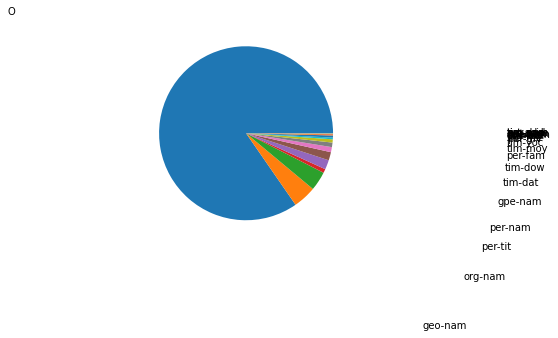

In [12]:
plt.pie( ner_tags.values(),labels=ner_tags.keys(),labeldistance=3);

# **Normalizing and vectorizing data**
in this section we will vectorize data to form that will use in Training 

In [13]:
# Read Processed Files 
files = glob.glob('./ner/*.tags')

#Concat All Files in One Csv File
df = pd.concat([pd.read_csv(f, header=None , names= ['text' , 'label' , 'pos']) for f in files], ignore_index= True)

In [14]:
df.head()

,text,label,pos
0,At least 60 people are confirmed dead and more...,O O O O O O O O O O O O O O O B-geo I-geo O O ...,IN JJS CD NNS VBP VBN JJ CC JJR IN CD VBP VBG ...
1,"More than 1,500 people have been rescued from ...",O O O O O O O O O O O O O O O O,JJR IN CD NNS VBP VBN VBN IN DT NNS IN DT JJ N...
2,"Primarily used for irrigation , the 25-meter-h...",O O O O O O O O O O O O O O O O O O O O O O O ...,"RB VBN IN NN , DT JJ , JJ NN VBD VBN IN DT NN ..."
3,"Members of Pakistan 's army , navy and coast g...",O O B-geo O O O B-org O B-org I-org O O O O O ...,"NNS IN NNP POS NN , NN CC NN NN VBP VBG NN NNS..."
4,"An estimated 50,000 people in the province hav...",O O O O O O O O O O O O O O O O O O O O O O O ...,DT VBN CD NNS IN DT NN VBP VBN VBN IN DT NN IN...


In [15]:
df.describe()

,text,label,pos
count,62010,62010,62010
unique,61333,42253,60824
top,VOA 's Mil Arcega reports .,O O O O O O O O O O O,NNP POS NNP NNP VBZ .
freq,18,566,46


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62010 entries, 0 to 62009
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    62010 non-null  object
 1   label   62010 non-null  object
 2   pos     62010 non-null  object
dtypes: object(3)
memory usage: 1.4+ MB


In [17]:
unique_chars = set()
for sentence in df['text']:
  for char in sentence:
    unique_chars.add(char)


In [18]:
for sentence in df['label']:
  for char in sentence:
    unique_chars.add(char)


In [19]:
for sentence in df['pos']:
  for char in sentence:
    unique_chars.add(char)


In [20]:
unique_chars

{' ',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '?',
 '@',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 ']',
 '_',
 '`',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '~',
 '\xa0',
 '°',
 'é',
 'ë',
 'ó',
 'ö',
 'ü',
 'ł',
 '–',
 '—',
 '‘',
 '’',
 '“',
 '”',
 '…',
 '\ufeff'}

In [21]:
# Tokenizing
text_tok = Tokenizer(filters='[\\]^\t\n', lower=False, split=' ', oov_token='<OOV>')
pos_tok = Tokenizer(filters='\t\n', lower=False, split=' ', oov_token='<OOV>')
ner_tok = Tokenizer(filters='\t\n', lower=False, split=' ', oov_token='<OOV>')

In [22]:
text_tok.fit_on_texts(df['text'])
pos_tok.fit_on_texts(df['pos'])
ner_tok.fit_on_texts(df['label'])

In [23]:
# print Configuration about TOkenizer
ner_config = ner_tok.get_config()
text_config = text_tok.get_config()
print(ner_config)

{'num_words': None, 'filters': '\t\n', 'lower': False, 'split': ' ', 'char_level': False, 'oov_token': '<OOV>', 'document_count': 62010, 'word_counts': '{"O": 1146068, "B-geo": 48876, "I-geo": 9512, "B-tim": 26296, "B-org": 26195, "I-org": 21899, "B-gpe": 20436, "I-tim": 8493, "B-per": 21984, "I-per": 22270, "I-gpe": 244, "B-art": 503, "B-eve": 391, "I-eve": 318, "I-art": 364, "B-nat": 238, "I-nat": 62}', 'word_docs': '{"B-geo": 31660, "B-tim": 22345, "I-geo": 7738, "O": 61999, "I-org": 11011, "B-org": 20478, "B-gpe": 16565, "I-tim": 5526, "B-per": 17499, "I-per": 13805, "I-gpe": 224, "B-art": 425, "I-eve": 201, "B-eve": 361, "I-art": 207, "B-nat": 211, "I-nat": 50}', 'index_docs': '{"3": 31660, "4": 22345, "10": 7738, "2": 61999, "8": 11011, "5": 20478, "9": 16565, "11": 5526, "7": 17499, "6": 13805, "16": 224, "12": 425, "15": 201, "13": 361, "14": 207, "17": 211, "18": 50}', 'index_word': '{"1": "<OOV>", "2": "O", "3": "B-geo", "4": "B-tim", "5": "B-org", "6": "I-per", "7": "B-per",

In [24]:
# we will need to convert between index to word in vice-versa

text_vocab = eval(text_config['index_word'])
ner_vocab = eval(ner_config['index_word'])

In [25]:
print(len(text_vocab))
len(ner_vocab)

39422


18

In [26]:
# To Sequence 
x_tok = text_tok.texts_to_sequences(df['text'])
y_tok = ner_tok.texts_to_sequences(df['label'])

In [27]:
print(x_tok[:1])
print(y_tok[:1])


[[356, 68, 952, 39, 29, 377, 332, 9, 50, 55, 2521, 519, 801, 44, 2, 12497, 23170, 3777, 12498, 5, 1616, 126, 75, 3]]
[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 10, 2, 2, 2, 2, 3, 4, 2]]


In [28]:
# Padding And Truncating Sequence To Same Length
MAX_LEN = 50 
x_pad = sequence.pad_sequences(x_tok,MAX_LEN,padding='post',truncating='post')
y_pad = sequence.pad_sequences(y_tok,MAX_LEN,padding='post',truncating='post')

In [29]:
print(x_pad.shape,y_pad.shape)

(62010, 50) (62010, 50)


In [30]:
NUM_CLASSES = len(ner_vocab) + 1 ## +1 for OOV
Y = tf.keras.utils.to_categorical(y_pad, num_classes=NUM_CLASSES)
Y.shape


(62010, 50, 19)

# **Splitting Data**

Make Sure The Splitted Data Dividable by BatchSize, Bcoz we use Bs as INput Shape

In [45]:
total_sentences = 62010
test_size = round(total_sentences / BATCH_SIZE * 0.2)
X_train = x_pad[BATCH_SIZE*test_size:]
Y_train = Y[BATCH_SIZE*test_size:]

X_test = x_pad[0:BATCH_SIZE*test_size]
Y_test = Y[0:BATCH_SIZE*test_size]

# **A BiLSTM model**

In [33]:
# Length of the vocabulary
vocab_size = len(text_vocab) + 1
# The embedding dimension
embedding_dim = 64
# Number of RNN units
rnn_units = 100
#batch size
BATCH_SIZE=90
#dropout
dropout = .2

In [47]:
def build_model_biLSTM(vocab_size,embedding_dim,rnn_units,batch_size ,num_classes):
  model = tf.keras.Sequential([
                               Embedding(vocab_size,embedding_dim,mask_zero=True,batch_input_shape=[batch_size,None]),
                               Bidirectional(LSTM(rnn_units,return_sequences=True,dropout=dropout,kernel_initializer=tf.keras.initializers.he_normal())),
                               TimeDistributed(Dense(rnn_units,activation='relu')),
                               Dense(NUM_CLASSES,activation='softmax')
                              ])
  return model

In [48]:
model = build_model_biLSTM(vocab_size,embedding_dim,rnn_units,BATCH_SIZE,NUM_CLASSES)

In [49]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (90, None, 64)            2523072   
_________________________________________________________________
bidirectional_2 (Bidirection (90, None, 200)           132000    
_________________________________________________________________
time_distributed_2 (TimeDist (90, None, 100)           20100     
_________________________________________________________________
dense_5 (Dense)              (90, None, 19)            1919      
Total params: 2,677,091
Trainable params: 2,677,091
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Compile Configuration
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [51]:
model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=15)


Epoch 1/15
551/551 [==============================] - 25s 37ms/step - loss: 0.1890 - accuracy: 0.9025
Epoch 2/15
551/551 [==============================] - 20s 37ms/step - loss: 0.0472 - accuracy: 0.9680
Epoch 3/15
551/551 [==============================] - 20s 36ms/step - loss: 0.0352 - accuracy: 0.9751
Epoch 4/15
551/551 [==============================] - 20s 37ms/step - loss: 0.0296 - accuracy: 0.9785
Epoch 5/15
551/551 [==============================] - 21s 38ms/step - loss: 0.0260 - accuracy: 0.9807
Epoch 6/15
551/551 [==============================] - 20s 36ms/step - loss: 0.0230 - accuracy: 0.9827
Epoch 7/15
551/551 [==============================] - 20s 36ms/step - loss: 0.0206 - accuracy: 0.9846
Epoch 8/15
551/551 [==============================] - 21s 38ms/step - loss: 0.0182 - accuracy: 0.9862
Epoch 9/15
551/551 [==============================] - 20s 36ms/step - loss: 0.0163 - accuracy: 0.9877
Epoch 10/15
551/551 [==============================] - 20s 36ms/step - loss: 0.014

In [52]:
model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)

138/138 [==============================] - 3s 8ms/step - loss: 0.0897 - accuracy: 0.9615


[0.0896502435207367, 0.9614908695220947]

**As good as this model is, it does not use an important characteristic of named entity
tags – a given tag is highly correlated with the tag coming after it. CRFs can take
advantage of this information and further improve the accuracy of NER tasks. Let's
understand how CRFs work and add them to the network above next.**

# **Conditional random fields (CRFs)**


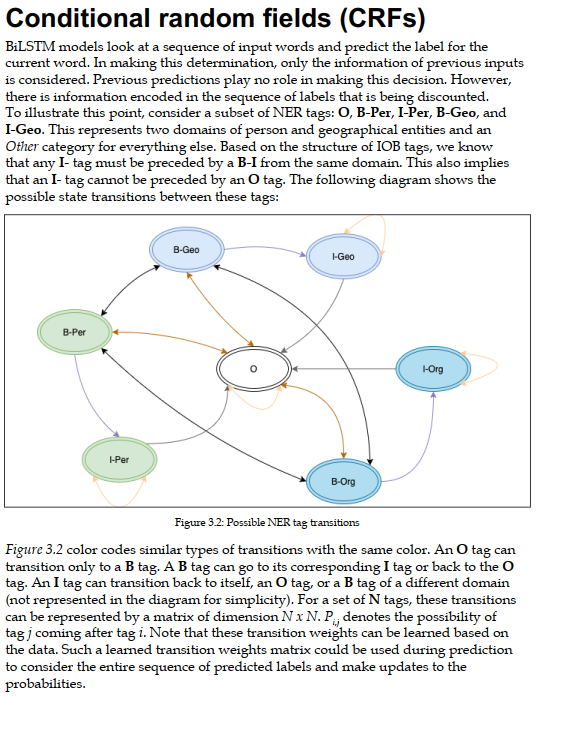
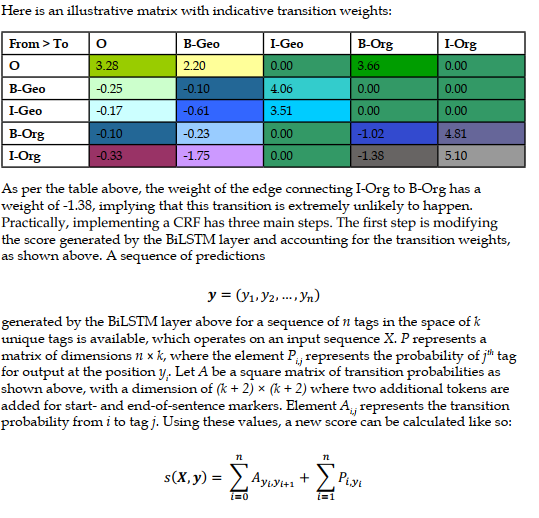
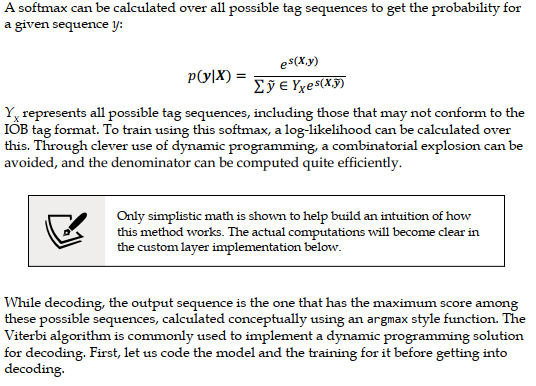

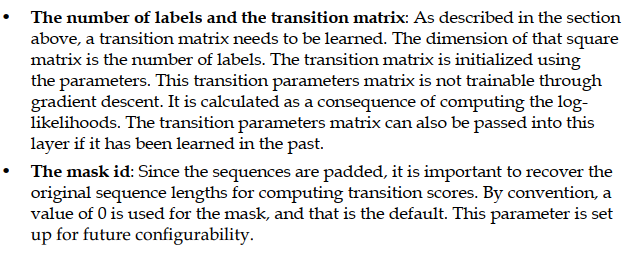

**CRF LAYER Not Provided as High level API so, we Will Create Custom Layer**

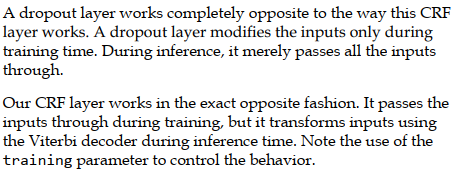

In [85]:
class CRFLayer(Layer):
  """
  Computes the log likelihood during training
  Performs Viterbi decoding during prediction
  """

  def __init__(self,label_size,mask_id=0,trans_params = None ,name = 'crf',**kwargs):
    super(CRFLayer, self).__init__(name = name ,**kwargs)
    self.label_size = label_size
    self.mask_id = mask_id
    self.transition_params = None
    if trans_params is None:  # not reloading pretrained params
        self.transition_params = tf.Variable(tf.random.uniform(shape=(label_size, label_size)),
                                         trainable=False)
    else:
        self.transition_params = trans_params
      
  def get_seq_lengths(self, matrix):

    """
    The log-likelihood function also requires the actual sequence lengths for each
    example. These sequence lengths can be computed from the labels and the mask
    identifier that was set up in the constructor of this layer (see above). This process is
    encapsulated in another convenience function, also part of the CRF layer
    """
    # matrix is of shape (batch_size, max_seq_len)
    mask = tf.not_equal(matrix, self.mask_id)
    seq_lengths = tf.math.reduce_sum(
                                    tf.cast(mask, dtype=tf.int32), 
                                    axis=-1)
    return seq_lengths

  def call(self, inputs, seq_lengths, training=None):
    if training is None:
        training = K.learning_phase()
    
    # during training, this layer just returns the logits
    # When models are trained with the fit() method, learning_
    # phase() returns True. When the .predict() method is called on a model, this flag is
    # set to false.

    if training:
        return inputs
    
    # viterbi decode logic to return proper 
    # results at inference
    _, max_seq_len, _ = inputs.shape
    seqlens = seq_lengths
    paths = []
    for logit, text_len in zip(inputs, seqlens):
        viterbi_path, _ = tfa.text.viterbi_decode(logit[:text_len], 
                                              self.transition_params)
        paths.append(self.pad_viterbi(viterbi_path, max_seq_len))

    return tf.convert_to_tensor(paths) 
  
  def pad_viterbi(self, viterbi, max_seq_len):
    if len(viterbi) < max_seq_len:
        viterbi = viterbi + [self.mask_id] * (max_seq_len - len(viterbi))
    return viterbi

  def get_proper_labels(self, y_true):
    shape = y_true.shape
    if len(shape) > 2:
        return tf.argmax(y_true, -1, output_type=tf.int32)
    return y_true
        
  def loss(self, y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(self.get_proper_labels(y_true), y_pred.dtype)

    seq_lengths = self.get_seq_lengths(y_true)
    log_likelihoods, self.transition_params = tfa.text.crf_log_likelihood(y_pred, 
                                                                y_true, seq_lengths)

    # save transition params
    self.transition_params = tf.Variable(self.transition_params, trainable=False)
    # calc loss
    loss = - tf.reduce_mean(log_likelihoods)
    return loss



In [86]:
class NerModel(tf.keras.Model):
    def __init__(self, hidden_num, vocab_size, label_size, embedding_size,
                name='BilstmCrfModel', **kwargs):
        super(NerModel, self).__init__(name=name, **kwargs)
        self.num_hidden = hidden_num
        self.vocab_size = vocab_size
        self.label_size = label_size

        self.embedding = Embedding(vocab_size, embedding_size, 
                                   mask_zero=True, name="embedding")
        self.biLSTM =Bidirectional(LSTM(hidden_num, return_sequences=True), name="bilstm")
        self.dense = TimeDistributed(tf.keras.layers.Dense(label_size), name="dense")
        self.crf = CRFLayer(self.label_size, name="crf")

    def call(self, text, labels=None, training=None):
        seq_lengths = tf.math.reduce_sum(tf.cast(tf.math.not_equal(text, 0), 
                                               dtype=tf.int32), axis=-1) 
        
        if training is None:
            training = K.learning_phase()

        inputs = self.embedding(text)
        bilstm = self.biLSTM(inputs)
        logits = self.dense(bilstm)
        outputs = self.crf(logits, seq_lengths, training)
        
        return outputs

In [87]:
vocab_size = len(text_vocab)+1 # len(chars)

# The embedding dimension
embedding_dim = 64

# Number of RNN units
rnn_units = 100

#batch size
BATCH_SIZE=90

# num of NER classes
num_classes = len(ner_vocab)+1

blc_model = NerModel(rnn_units, vocab_size, num_classes, embedding_dim, dynamic=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [88]:
# create training and testing splits
total_sentences = 62010
test_size = round(total_sentences / BATCH_SIZE * 0.2)
X_train = x_pad[BATCH_SIZE*test_size:]
Y_train = Y[BATCH_SIZE*test_size:]

X_test = x_pad[0:BATCH_SIZE*test_size]
Y_test = Y[0:BATCH_SIZE*test_size]
Y_train_int = tf.cast(Y_train, dtype=tf.int32)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train_int))
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [89]:
loss_metric = tf.keras.metrics.Mean()

epochs = 5

# Iterate over epochs.
for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (text_batch, labels_batch) in enumerate(train_dataset):
        labels_max = tf.argmax(labels_batch, -1, output_type=tf.int32)
        with tf.GradientTape() as tape:
            logits = blc_model(text_batch, training=True)
            loss = blc_model.crf.loss(labels_max, logits)

            grads = tape.gradient(loss, blc_model.trainable_weights)
            optimizer.apply_gradients(zip(grads, blc_model.trainable_weights))
            
            loss_metric(loss)
        if step % 50 == 0:
          print('step %s: mean loss = %s' % (step, loss_metric.result()))

Start of epoch 0
step 0: mean loss = tf.Tensor(59.99873, shape=(), dtype=float32)
step 50: mean loss = tf.Tensor(31.808453, shape=(), dtype=float32)
step 100: mean loss = tf.Tensor(24.319809, shape=(), dtype=float32)
step 150: mean loss = tf.Tensor(20.963394, shape=(), dtype=float32)
step 200: mean loss = tf.Tensor(18.452284, shape=(), dtype=float32)
step 250: mean loss = tf.Tensor(16.575895, shape=(), dtype=float32)
step 300: mean loss = tf.Tensor(15.1869, shape=(), dtype=float32)
step 350: mean loss = tf.Tensor(14.056028, shape=(), dtype=float32)
step 400: mean loss = tf.Tensor(13.090817, shape=(), dtype=float32)
step 450: mean loss = tf.Tensor(12.222341, shape=(), dtype=float32)
step 500: mean loss = tf.Tensor(11.462102, shape=(), dtype=float32)
step 550: mean loss = tf.Tensor(10.812995, shape=(), dtype=float32)
Start of epoch 1
step 0: mean loss = tf.Tensor(10.798678, shape=(), dtype=float32)
step 50: mean loss = tf.Tensor(10.221907, shape=(), dtype=float32)
step 100: mean loss = t

In [90]:
Y_test_int = tf.cast(Y_test, dtype=tf.int32)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test_int))
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [91]:
out = blc_model.predict(test_dataset.take(1))


In [92]:
# check the outputs
print(out[1], tf.argmax(Y_test[1], -1))
print(out[2], tf.argmax(Y_test[2], -1))

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0] tf.Tensor(
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(50,), dtype=int64)
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0
 0 0 0 0 0 0 0 0 0 0 0 0 0] tf.Tensor(
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0
 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(50,), dtype=int64)


In [93]:
print("Ground Truth: ", ner_tok.sequences_to_texts([tf.argmax(Y_test[2], -1).numpy()]))
print("Prediction: ", ner_tok.sequences_to_texts([out[2]]))

Ground Truth:  ['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']
Prediction:  ['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']


In [94]:
def np_precision(pred, true):
    # expect numpy arrays
    assert pred.shape == true.shape
    assert len(pred.shape) == 2
    mask_pred = np.ma.masked_equal(pred, 0)
    mask_true = np.ma.masked_equal(true, 0)
    acc = np.equal(mask_pred, mask_true)
    return np.mean(acc.compressed().astype(int))

In [95]:
np_precision(out, tf.argmax(Y_test[:BATCH_SIZE], -1).numpy())


0.9671882887430591